In [3]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving X_test.pt to X_test.pt
Saving X_train.pt to X_train.pt
Saving X_valid.pt to X_valid.pt
Saving y_test.pt to y_test.pt
Saving y_train.pt to y_train.pt
Saving y_valid.pt to y_valid.pt
User uploaded file "X_test.pt" with length 1600727 bytes
User uploaded file "X_train.pt" with length 12806364 bytes
User uploaded file "X_valid.pt" with length 1600732 bytes
User uploaded file "y_test.pt" with length 11799 bytes
User uploaded file "y_train.pt" with length 86492 bytes
User uploaded file "y_valid.pt" with length 11804 bytes


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


epoch: 1, loss_train: 0.2310, accuracy_train: 0.9230, loss_valid: 0.3138, accuracy_valid: 0.8822, train_time: 0.5273sec
epoch: 2, loss_train: 0.2008, accuracy_train: 0.9287, loss_valid: 0.3063, accuracy_valid: 0.8995, train_time: 0.3333sec
epoch: 3, loss_train: 0.1632, accuracy_train: 0.9444, loss_valid: 0.3092, accuracy_valid: 0.8957, train_time: 0.3477sec
epoch: 4, loss_train: 0.1486, accuracy_train: 0.9472, loss_valid: 0.3280, accuracy_valid: 0.8897, train_time: 0.3299sec
epoch: 5, loss_train: 0.1398, accuracy_train: 0.9544, loss_valid: 0.3292, accuracy_valid: 0.8957, train_time: 0.3507sec
epoch: 6, loss_train: 0.0950, accuracy_train: 0.9712, loss_valid: 0.3356, accuracy_valid: 0.9025, train_time: 0.3329sec
epoch: 7, loss_train: 0.0796, accuracy_train: 0.9730, loss_valid: 0.3480, accuracy_valid: 0.8995, train_time: 0.3507sec
epoch: 8, loss_train: 0.1530, accuracy_train: 0.9404, loss_valid: 0.4437, accuracy_valid: 0.8717, train_time: 0.3367sec
epoch: 9, loss_train: 0.0474, accuracy_t

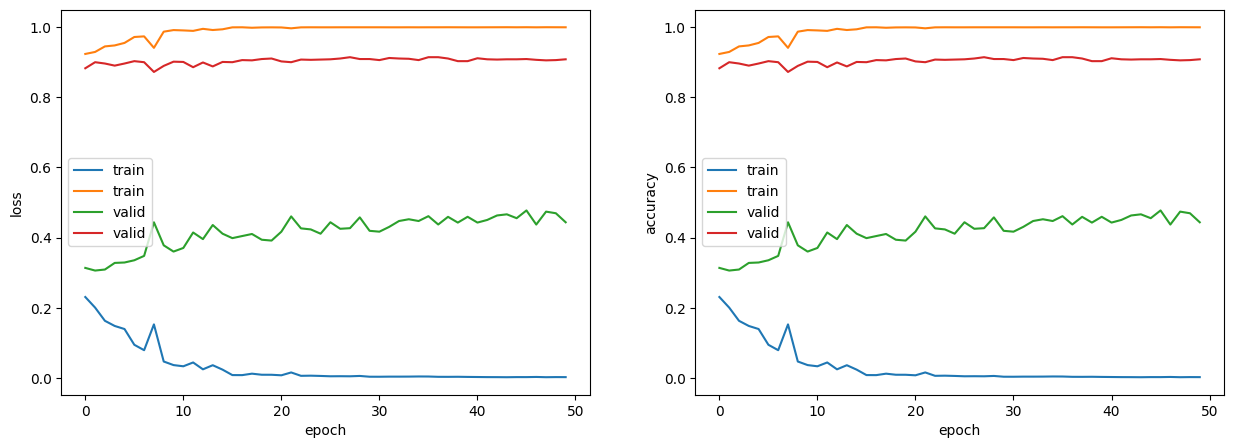

In [8]:
# 79. 多層ニューラルネットワーク

from torch import nn
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import numpy as np
import time
from torch.nn import functional as F


class MultiLayerPerceptronNetwork(nn.Module):
    def __init__(self, input_size, mid_size, output_size, mid_layers):
        super().__init__()
        self.mid_layers = mid_layers
        self.fc = nn.Linear(input_size, mid_size)
        self.fc_mid = nn.Linear(mid_size, mid_size)
        self.fc_out = nn.Linear(mid_size, output_size)
        self.bn = nn.BatchNorm1d(mid_size)

    def forward(self, x):
        x = F.relu(self.fc(x))
        for _ in range(self.mid_layers):
            x = F.relu(self.bn(self.fc_mid(x)))
        x = F.relu(self.fc_out(x))
        return x


X_train = torch.load("X_train.pt")
model = MultiLayerPerceptronNetwork(300, 200, 4, 1)


class NewsDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return [self.x[idx], self.y[idx]]


def calc_acc(model, loader, device):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)  # deviceに移動
            labels = labels.to(device)  # deviceに移動
            outputs = model(inputs)
            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()

        return correct / total


def calc_loss_acc(model, criterion, loader, device):  # deviceを引数に追加
    model.eval()
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)  # deviceに移動
            labels = labels.to(device)  # deviceに移動
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()

        return loss / len(loader), correct / total


X_train = torch.load("X_train.pt")
X_valid = torch.load("X_valid.pt")
X_test = torch.load("X_test.pt")
y_train = torch.load("y_train.pt")
y_valid = torch.load("y_valid.pt")
y_test = torch.load("y_test.pt")

dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)
dataset_test = NewsDataset(X_test, y_test)

dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)
dataloader_valid = DataLoader(
    dataset_valid, batch_size=len(dataset_valid), shuffle=False)
dataloader_test = DataLoader(
    dataset_test, batch_size=len(dataset_test), shuffle=False)

log_train = []
log_valid = []


def train_model(dataset_train, dataset_valid, batch_size, model, criterion, num_epochs, device=None):
    model.to(device)  # 追加

    dataloader_train = DataLoader(
        dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_valid = DataLoader(
        dataset_valid, batch_size=len(dataset_valid), shuffle=False)

    for epoch in range(num_epochs):
        start_time = time.time()

        model.train()
        loss_train = 0.0
        for inputs, labels in dataloader_train:
            optimizer.zero_grad()

            inputs = inputs.to(device)  # deviceに移動
            labels = labels.to(device)  # deviceに移動
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        end_time = time.time()

        loss_train, acc_train = calc_loss_acc(
            model, criterion, dataloader_train, device)
        loss_valid, acc_valid = calc_loss_acc(
            model, criterion, dataloader_valid, device)
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])

        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(
        ), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, train_time: {(end_time - start_time):.4f}sec')


model = MultiLayerPerceptronNetwork(300, 200, 4, 1)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)
num_epochs = 50
device = torch.device("cuda")
batch_size = 64
train_model(dataset_train, dataset_valid,
            batch_size, model, criterion, num_epochs, device)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.array(log_train), label='train')
ax[0].plot(np.array(log_valid), label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(np.array(log_train), label='train')
ax[1].plot(np.array(log_valid), label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.savefig("knock79.png")

acc_train = calc_acc(model, dataloader_train, device)
acc_test = calc_acc(model, dataloader_test, device)
print(f"train_acc : {acc_train}")
print(f"test_acc : {acc_test}")